## 모듈 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
!sudo apt-get install -y fonts-nanum #코랩 한글 폰트 꺠짐 방지 폰트 설치
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
import re
import urllib.request

from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 한글

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 한국어 출력
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath,size=9)
plt.rc('font',family='NanumBarunGothic')

## 데이터 확인 - Mecab 전처리 끝난

In [3]:
news = pd.read_csv('./drive/MyDrive/final_project/final_df.csv', index_col=0) 
news.tail()

,name,headline,date,change,token_mecab
233699,SK하이닉스,"""코로나 봉쇄로 삼성 시안공장 생산 줄여…메모리 공급사 주가에는 긍정적 영향""",2021-12-30,1,코로나 봉쇄 삼성 시안 공장 생산 메모리 공급 주가 긍정 영향
233700,SK하이닉스,"SK하이닉스, 인텔 낸드 1단계 인수",2021-12-30,1,SK 하이닉스 인텔 낸드 단계 인수
233701,SK하이닉스,"SK하이닉스, 특별성과급 300% 쏜다",2021-12-30,1,SK 하이닉스 특별
233702,셀트리온,"삼성바이오로직스-셀트리온, 바이오 대장주 희비",2021-12-30,0,삼성 바이오 로직스 트리 장주 희비
233703,신한지주,배당락에 3000선 내줬지만…“코스피 하락폭 예상보다 작았다”,2021-12-30,0,배당락 코스피 하락 예상


## 데이터 분리 - train (2012 ~ 2019), test (2020 ~ 2021)

In [4]:
news['date'] = pd.to_datetime(news['date'])

split_date = pd.to_datetime('2020-01-01')

train = news[news['date'] < split_date]
test = news[news['date'] >= split_date]

In [5]:
len(train), len(test)

(188530, 45174)

- train과 test를 20년도를 기준으로 나누었고 약 8:2 비율로 나뉘었다.

## 널값 제거

In [6]:
train.dropna(how='any', inplace=True)
test.dropna(how='any', inplace=True)

In [7]:
train.reset_index(inplace=True); test.reset_index(inplace=True)

## 정수 인코딩 작업을 위해 text를 token 단위로 분리

In [8]:
X_train = []
for sentence in tqdm(train['token_mecab']):
    temp_list = []
    for word in sentence.split():
        temp_list.append(word)
    X_train.append(temp_list)    

100%|██████████| 188501/188501 [00:00<00:00, 247542.75it/s]


In [9]:
X_train[:5]

[['TV', '재계', '총수', '일자리', '창출', '투자', '확대', '강조'],
 ['코스닥', '새해', '거래일', '소폭', '오름세', '지속'],
 ['코스닥', '새해', '거래일', '소폭', '오름세', '지속'],
 ['코스닥', '개인', '기관', '사자', '상승', '지속', '저출산', '종목', '강세'],
 ['코스피', '외인', '팔자', '약세', '전환', '방향', '탐색']]

In [10]:
X_test = []
for sentence in tqdm(test['token_mecab']):
    temp_list = []
    for word in sentence.split():
        temp_list.append(word)
    X_test.append(temp_list)    

100%|██████████| 45172/45172 [00:00<00:00, 412789.69it/s]


In [11]:
X_test[:5]

[['기술', '사대주의', 'AI', '정복', '힘들'],
 ['해설', '중국', '디지털', '종속', '우려', '동남아', '국가', '중국', 'QR', '결제', '금지', '강수'],
 ['씨티', '은행', '포인트', '금리', '인하', '직장', '신용', '대출', '연장', '이벤트'],
 ['소비자', '분쟁', '통지서', '카톡', '제공'],
 ['이슈', '분석', '공정위', '배민', 'DH', '합병', '경우']]

## 단어 집합(vocabulary) 생성


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
len(tokenizer.word_index)

35750

- 단어가 3만5천개가 넘게 존재한다.
- 부여된 정수는 등장 빈도순으로 차례로 부여되었다.
- 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮은 것
- 빈도수가 낮은 단어들을 자연어처리에서 배제하기 위해 등장 빈도수에 따라 비중을 확인하면서 정제 진행

### 빈도수 확인
- 상승/하락에 따른 빈도수로 나누어 확인하자
- 겹치는 조사 및 공통어를 불용어로 추가해 제거

In [14]:
frequencies = pd.Series(np.concatenate([word for word in X_train])).value_counts()
frequencies

코스피      15508
금융       15194
코스닥      10267
삼성        9907
KB        9597
         ...  
조웅래          1
후버           1
표가           1
KAMCO        1
어류           1
Length: 36017, dtype: int64

In [15]:
train['tokens'] = X_train # 토큰화된 mecab 문장들 컬럼 추가
train.head(3)

,index,name,headline,date,change,token_mecab,tokens
0,0,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",2012-01-02,1,TV 재계 총수 일자리 창출 투자 확대 강조,"[TV, 재계, 총수, 일자리, 창출, 투자, 확대, 강조]"
1,1,셀트리온,"코스닥, 새해 첫 거래일 소폭 오름세 지속",2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속,"[코스닥, 새해, 거래일, 소폭, 오름세, 지속]"
2,2,셀트리온,코스닥 새해 첫 거래일 소폭 오름세 지속,2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속,"[코스닥, 새해, 거래일, 소폭, 오름세, 지속]"


## 단어 등장 빈도 시각화 
- 전체 헤드라인 분포 확인 후 주가 변동 상승/하락으로 나누어 분포 확인
- 상승/하락의 공통어 빈도수를 확인하면서 불용어 처리

In [16]:
def get_freq_count(tokens):
  pos_token = list(train['tokens'][train['change'] == 1])
  neg_token = list(train['tokens'][train['change'] == 0])
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

def remove_doubled_words(pos_freq, neg_freq, tokens):
  # 긍정,부정에서 모두 사용되는 단어는 의미 없는 단어이므로 제거
  top_50_pos = pos_freq[:20]
  top_50_neg = neg_freq[:20]
  remove_words = [p for p in top_50_pos.index if p in top_50_neg.index]
  tokens_removed = remove_stop_words(tokens, remove_words)
  final_tokens = cleaning_tokens(tokens_removed)
  return final_tokens

def draw_top_hist(data,name,color): # 히스토그램을 그려줍니다.
  top_10 = data[:10]
  plt.figure(figsize=(12,7.5))
  plt.rc('font', family='NanumBarunGothic') 
  plt.suptitle("단어 등장 빈도 수", fontsize=30)
  plt.title(name, fontsize=15)
  plt.bar(top_10.index,top_10.values, width=0.5, color= color, alpha=0.5)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [17]:
tokens = pd.Series(X_train) # 인덱싱을 위해 시리즈로 변환
tokens[:5]

0         [TV, 재계, 총수, 일자리, 창출, 투자, 확대, 강조]
1               [코스닥, 새해, 거래일, 소폭, 오름세, 지속]
2               [코스닥, 새해, 거래일, 소폭, 오름세, 지속]
3    [코스닥, 개인, 기관, 사자, 상승, 지속, 저출산, 종목, 강세]
4             [코스피, 외인, 팔자, 약세, 전환, 방향, 탐색]
dtype: object

In [18]:
pos_freq, neg_freq = get_freq_count(tokens)

### 헤드라인 단어 등장 빈도 수 확인

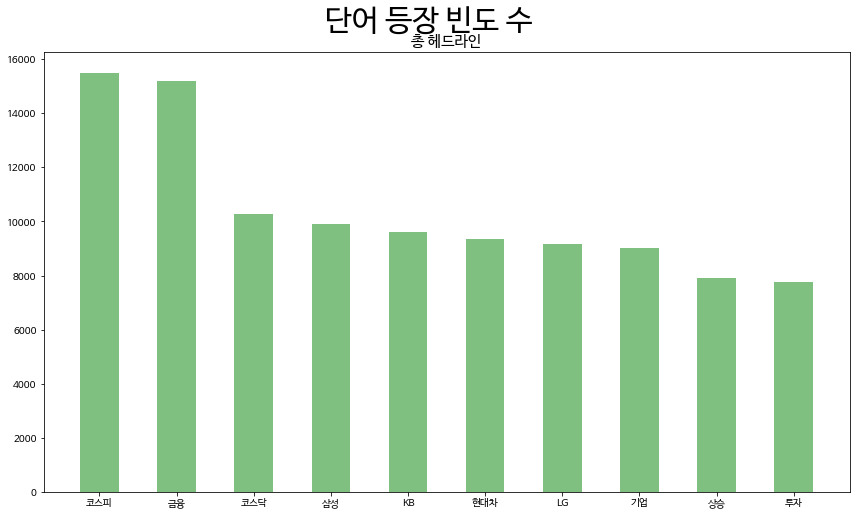

In [19]:
draw_top_hist(frequencies,'총 헤드라인','g') # 총

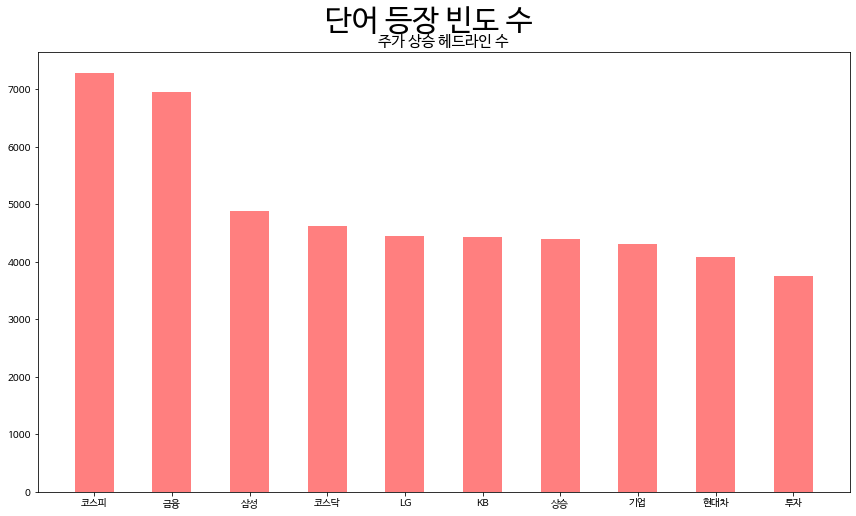

In [20]:
draw_top_hist(pos_freq,'주가 상승 헤드라인 수','r') # 상승

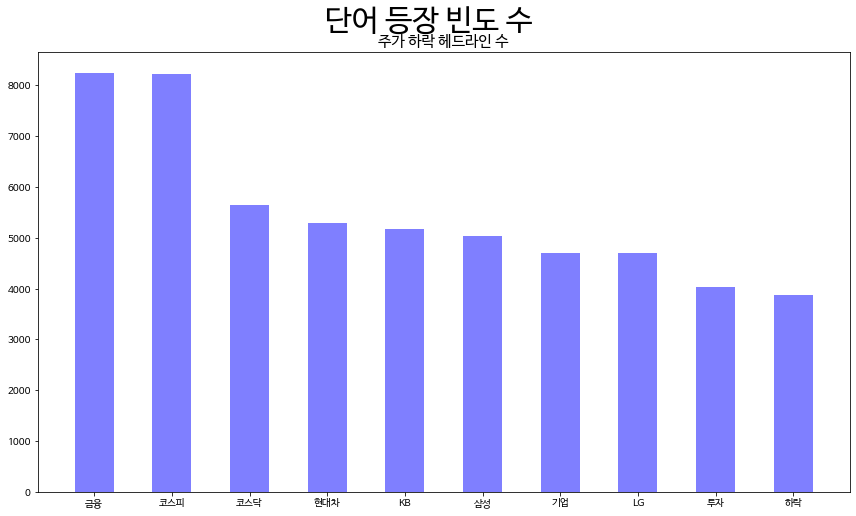

In [21]:
draw_top_hist(neg_freq,'주가 하락 헤드라인 수','b') # 하락

### 상위 10개 단어 중 상승/하락 공통 토큰 불용어 처리


In [22]:
top_50_pos = pos_freq[:10]
top_50_neg = neg_freq[:10]
common_words = [p for p in top_50_pos.index if p in top_50_neg.index]
common_words

['코스피', '금융', '삼성', '코스닥', 'LG', 'KB', '기업', '현대차', '투자']

- 상위 10위에 공동으로 존재하는 토큰들은 전부 제거

In [23]:
total = frequencies.sum()
common_words_cnt = frequencies[common_words].sum()
print(f'total words count: {total} removed: {common_words_cnt} ratio: {common_words_cnt / total :.2f}')

total words count: 1255421 removed: 95771 ratio: 0.08


- 전체 단어 사용 횟수 중 8% 정도의 빈도수가 겹치는 공통어
- 이 공통어들을 불용어로 처리해 제거

In [24]:
clean_token_list = []
for token in tokens:
  clean_token = list(filter(lambda x: x not in common_words,token))
  clean_token_list.append(clean_token)

In [25]:
clean_tokens = pd.Series(clean_token_list)
clean_tokens[:10]

0         [TV, 재계, 총수, 일자리, 창출, 확대, 강조]
1                [새해, 거래일, 소폭, 오름세, 지속]
2                [새해, 거래일, 소폭, 오름세, 지속]
3     [개인, 기관, 사자, 상승, 지속, 저출산, 종목, 강세]
4              [외인, 팔자, 약세, 전환, 방향, 탐색]
5                        [거래일, 상승세, 상승]
6                 [새해, 거래일, 개인, 매수, 상승]
7    [IR, 장영, 실상, 화학, 장갑, 소재, NBR, 라텍스]
8               [주목, CEO, 김반석, 화학, 부회장]
9                         [정유, 화학주, 하락]
dtype: object

In [26]:
train['clean_tokens'] = clean_token_list # 상위 10개 공동 토큰 처리한 문장 컬럼 추가
train.head(3)

,index,name,headline,date,change,token_mecab,tokens,clean_tokens
0,0,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",2012-01-02,1,TV 재계 총수 일자리 창출 투자 확대 강조,"[TV, 재계, 총수, 일자리, 창출, 투자, 확대, 강조]","[TV, 재계, 총수, 일자리, 창출, 확대, 강조]"
1,1,셀트리온,"코스닥, 새해 첫 거래일 소폭 오름세 지속",2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속,"[코스닥, 새해, 거래일, 소폭, 오름세, 지속]","[새해, 거래일, 소폭, 오름세, 지속]"
2,2,셀트리온,코스닥 새해 첫 거래일 소폭 오름세 지속,2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속,"[코스닥, 새해, 거래일, 소폭, 오름세, 지속]","[새해, 거래일, 소폭, 오름세, 지속]"


## 상위 10개 공동 토큰 처리 후 한번 더 단어 등장 빈도 수 확인 (상승/하락)

In [27]:
def get_freq_count2(tokens):
  pos_token = list(train['clean_tokens'][train['change'] == 1])
  neg_token = list(train['clean_tokens'][train['change'] == 0])
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

In [28]:
pos_freq,neg_freq = get_freq_count2(clean_tokens)

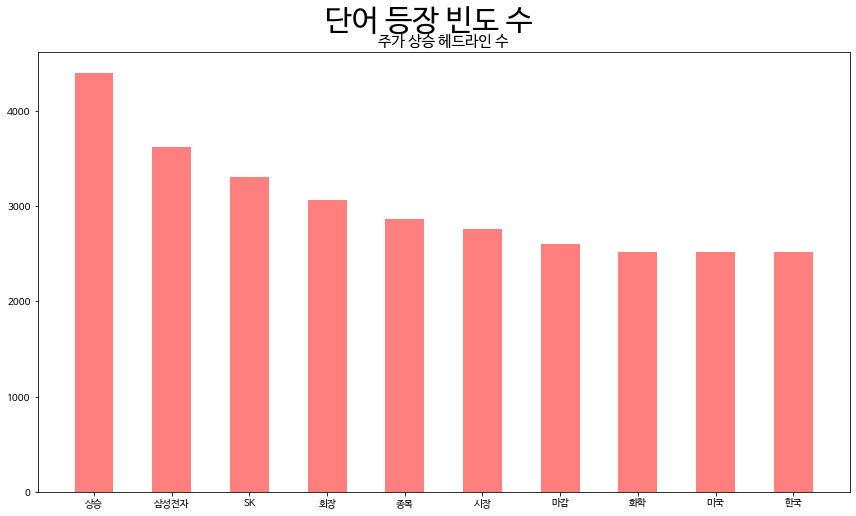

In [ ]:
draw_top_hist(pos_freq,'주가 상승 헤드라인 수','r')

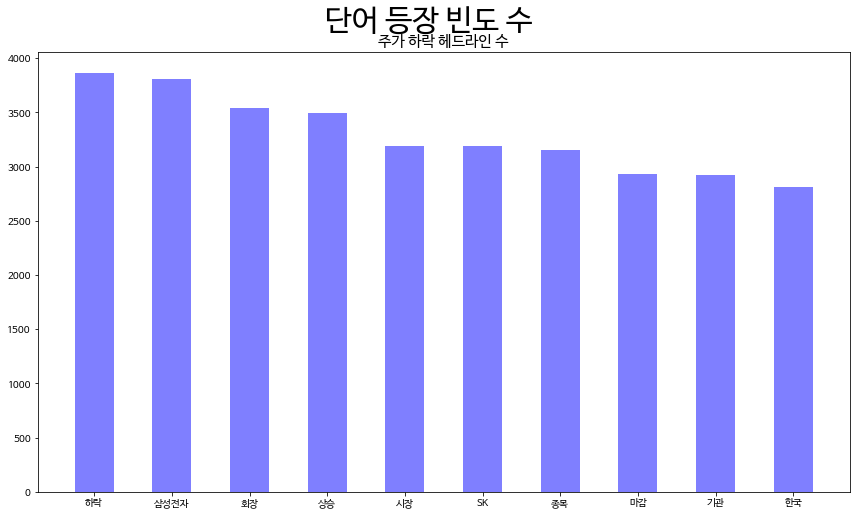

In [ ]:
draw_top_hist(neg_freq,'주가 하락 헤드라인 수','b')

### 한번 더 상위 10개의 공동 토큰 제거

- 아직까지 공통 토큰들이 좀 보인다 한번 더 제거

In [29]:
top_50_pos2 = pos_freq[:10]
top_50_neg2 = neg_freq[:10]
common_words = [p for p in top_50_pos2.index if p in top_50_neg2.index]
common_words = common_words[1:] # 상승은 중요한 단어 -> 주가 변동이 상승일 때
common_words

['삼성전자', 'SK', '회장', '종목', '시장', '마감', '한국']

In [30]:
total = frequencies.sum()
common_words_cnt = frequencies[common_words].sum()
print(f'total words count: {total} removed: {common_words_cnt} ratio: {common_words_cnt / total :.2f}')

total words count: 1255421 removed: 43350 ratio: 0.03


- 전체 단어 중 3% 공통어

In [31]:
clean_token_list2 = []
for token in clean_tokens:
  clean_token = list(filter(lambda x: x not in common_words,token))
  clean_token_list2.append(clean_token)

In [32]:
clean_tokens2 = pd.Series(clean_token_list2)
clean_tokens2[:10]

0         [TV, 재계, 총수, 일자리, 창출, 확대, 강조]
1                [새해, 거래일, 소폭, 오름세, 지속]
2                [새해, 거래일, 소폭, 오름세, 지속]
3         [개인, 기관, 사자, 상승, 지속, 저출산, 강세]
4              [외인, 팔자, 약세, 전환, 방향, 탐색]
5                        [거래일, 상승세, 상승]
6                 [새해, 거래일, 개인, 매수, 상승]
7    [IR, 장영, 실상, 화학, 장갑, 소재, NBR, 라텍스]
8               [주목, CEO, 김반석, 화학, 부회장]
9                         [정유, 화학주, 하락]
dtype: object

In [33]:
train['clean_tokens2'] = clean_token_list2 # 최종 clean_token_list 추가
train.head(3)

,index,name,headline,date,change,token_mecab,tokens,clean_tokens,clean_tokens2
0,0,삼성전자,"[TV] 재계 총수들, 일자리 창출과 투자 확대 강조",2012-01-02,1,TV 재계 총수 일자리 창출 투자 확대 강조,"[TV, 재계, 총수, 일자리, 창출, 투자, 확대, 강조]","[TV, 재계, 총수, 일자리, 창출, 확대, 강조]","[TV, 재계, 총수, 일자리, 창출, 확대, 강조]"
1,1,셀트리온,"코스닥, 새해 첫 거래일 소폭 오름세 지속",2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속,"[코스닥, 새해, 거래일, 소폭, 오름세, 지속]","[새해, 거래일, 소폭, 오름세, 지속]","[새해, 거래일, 소폭, 오름세, 지속]"
2,2,셀트리온,코스닥 새해 첫 거래일 소폭 오름세 지속,2012-01-02,0,코스닥 새해 거래일 소폭 오름세 지속,"[코스닥, 새해, 거래일, 소폭, 오름세, 지속]","[새해, 거래일, 소폭, 오름세, 지속]","[새해, 거래일, 소폭, 오름세, 지속]"


## 최종 주가 변동 별 단어 등장 빈도 수 확인

In [ ]:
def get_freq_count3(tokens):
  pos_token = list(train['clean_tokens2'][train['change'] == 1])
  neg_token = list(train['clean_tokens2'][train['change'] == 0])
  pos_freq = pd.Series(np.concatenate([w for w in pos_token])).value_counts()
  neg_freq = pd.Series(np.concatenate([w for w in neg_token])).value_counts()
  return pos_freq, neg_freq

In [ ]:
pos_freq,neg_freq = get_freq_count3(clean_tokens2)

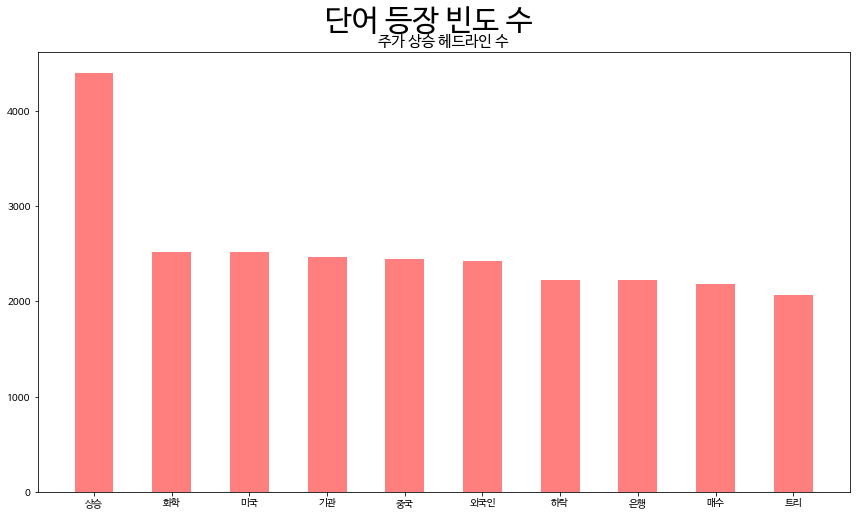

In [ ]:
draw_top_hist(pos_freq,'주가 상승 헤드라인 수','r')

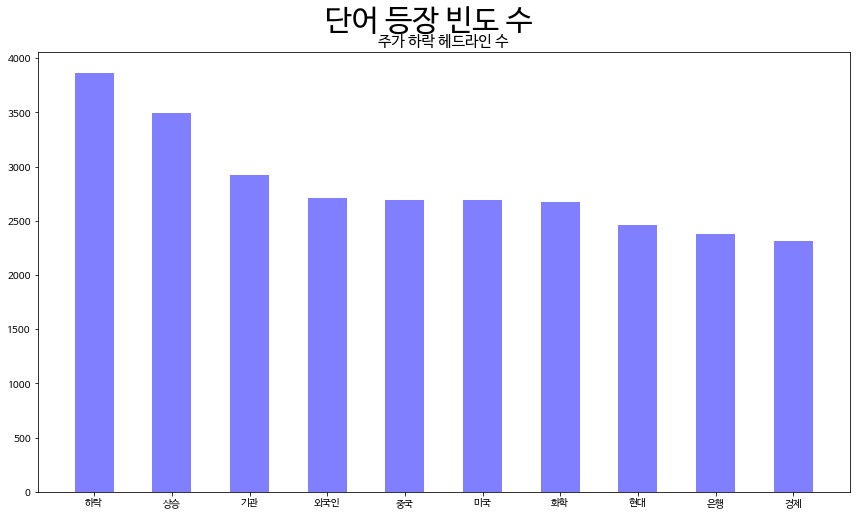

In [ ]:
draw_top_hist(neg_freq,'주가 하락 헤드라인 수','b')

In [ ]:
print(f"Words kinds: {len(frequencies)}")

Words kinds: 36017


- 약 36000개 정도의 단어를 사용하고 있다.
- 모두 사용해야 될까?

## 단어 개수에 따른 빈도수 분포 확인

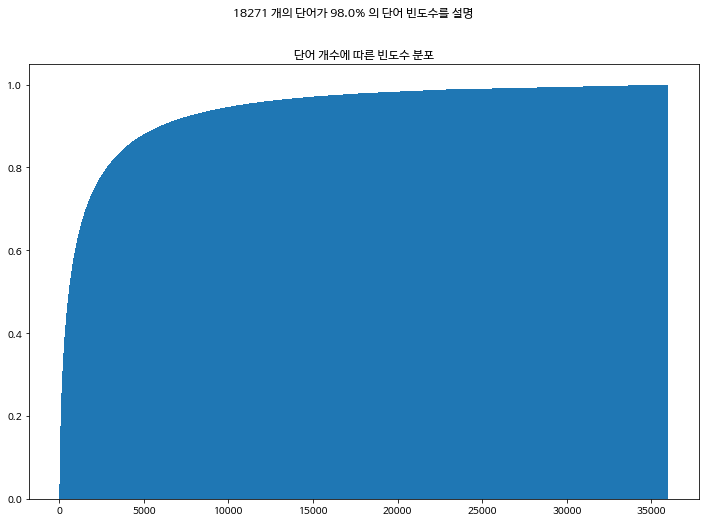

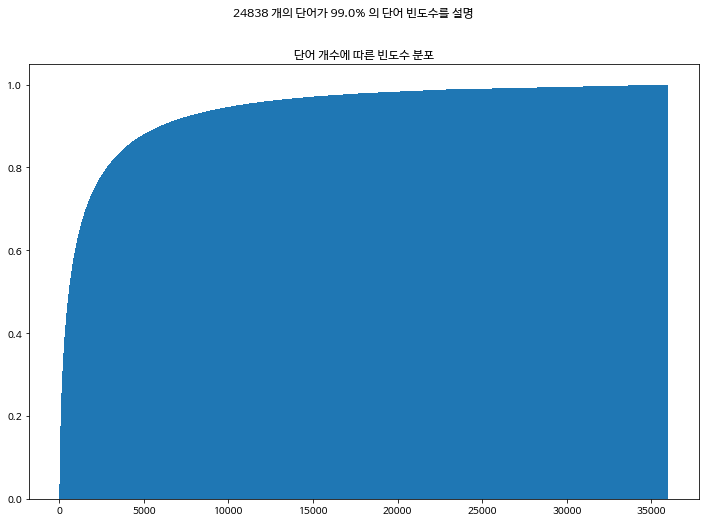

In [35]:
for rate in [0.98, 0.99]:
    clean_frequencies = pd.Series(np.concatenate([w for w in clean_tokens2])).value_counts()
    accumulate_words = np.add.accumulate(clean_frequencies) # 빈도수의 누적합을 구해줍니다.
    ratio = rate
    words_cnt = np.where(accumulate_words > sum(clean_frequencies) * rate)[0][0]
    plt.figure(figsize=(12,8))
    plt.bar(range(0,len(clean_frequencies)), accumulate_words / sum(clean_frequencies), width=1.0) # 전체 단어와 현재까지의 빈도수의 비율을 구해줍니다.
    plt.title('단어 개수에 따른 빈도수 분포')
    plt.suptitle(f'{words_cnt} 개의 단어가 {ratio * 100:.1f}% 의 단어 빈도수를 설명')

- 98 ~ 99%의 빈도수를 설명하려면 약 18200 ~ 24800개가 필요

No handles with labels found to put in legend.


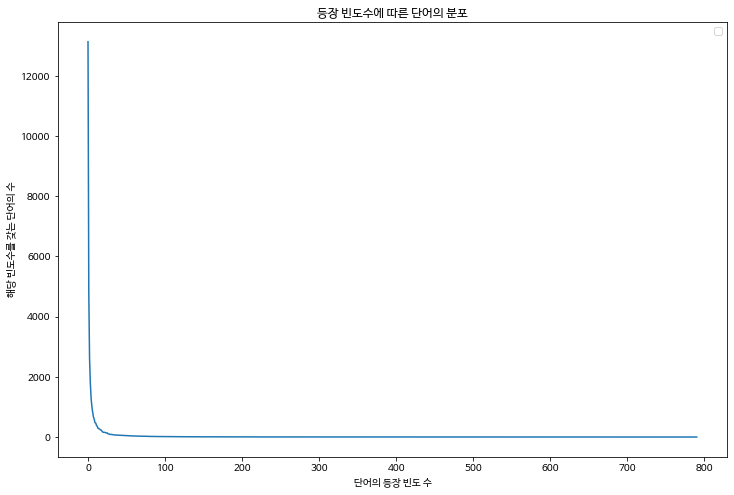

In [36]:
words_distribution = clean_frequencies.value_counts()
plt.figure(figsize=(12,8))
plt.plot(range(0,len(words_distribution)), words_distribution.values)
plt.ylabel("해당 빈도수를 갖는 단어의 수")
plt.xlabel("단어의 등장 빈도 수")
plt.title("등장 빈도수에 따른 단어의 분포")
plt.legend()

- 그래프를 살펴보면 빈도수가 높아질 수록 해당하는 단어의 수도 줄어든다.
- 빈도수가 낮은 단어의 수가 압도적으로 많으므로 단어 전체 분포를 설명하기 위해선 많은 단어가 필요하다.

### 등장 빈도가 적은 단어들을 단어 집합에서 제외

#### 위에서 정제한 2번의 공동 토큰 처리를 한 총 단어의 수를 가져오자

- 등장 빈도가 1회 이하인 단어들이 실제 train 데이터에서 등장 빈도로 차지하는 비중은 약 1.15%
- 등장 빈도가 1회 이하인 단어들은 정수 인코딩 과정에서 배제 
- 약 22700개 정도의 단어가 남으므로 98~99%의 단어 빈도수를 설명

In [37]:
X_train = train.clean_tokens2 # train 데이터 문서 추출
y_train = train.change # train 데이터에서 라벨 추출

X_test = test.token_mecab # test 데이터 문서 추출
y_test = test.change      # test 데이터 라벨 추출

In [38]:
def check_frequency(num,tokenizer):
  threshold = num
  total_cnt = len(tokenizer.word_index) # 단어의 수
  rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
  total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
  rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
  for key, value in tokenizer.word_counts.items():
      total_freq += value

      # 단어의 등장 빈도수가 threshold보다 작으면
      if(value < threshold):
          rare_cnt += 1
          rare_freq += value

  print('단어 집합(vocabulary)의 크기 :',total_cnt)
  print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
  print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
  print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

  return total_cnt, rare_cnt

In [39]:
# 전체 단어 개수 중 빈도수 1 이하인 단어는 제거하기 위한 작업


# 빈도 확인해보기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt, rare_cnt = check_frequency(threshold, tokenizer)
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

# tokenizer
myTokenizer = Tokenizer(vocab_size)
myTokenizer.fit_on_texts(X_train)

# 정수 sequences로 encoding
X_train = myTokenizer.texts_to_sequences(X_train)
X_test = myTokenizer.texts_to_sequences(X_test)

# check_data
print(X_train[0])
print(X_test[0])

단어 집합(vocabulary)의 크기 : 35737
등장 빈도가 1번 이하인 희귀 단어의 수: 12942
단어 집합에서 희귀 단어의 비율: 36.214567535047706
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1593657618919644
단어 집합의 크기 : 22796
[49, 208, 350, 224, 682, 39, 1273]
[57, 227, 7466, 2866]


### 정수 인코딩
- 단어 집합의 크기는 22796개 -> 토크나이저로 넘겨줌
- 텍스트 시퀀스를 정수 시퀀스로 변환

In [40]:
print(X_train[:3])

[[49, 208, 350, 224, 682, 39, 1273], [980, 234, 237, 1177, 55], [980, 234, 237, 1177, 55]]


#### 라벨 분리

In [41]:
y_train = np.array(train['change'])
y_test = np.array(test['change'])

## 빈 샘플(empty samples) 제거
- 전체 데이터에서 빈도수가 1이하인 단어가 삭제되었을 때 빈 샘플이 있을 수 있음
- 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 제거해줘야한다.

In [42]:
len(X_train), len(y_train)

(188501, 188501)

In [43]:
# 길이가 0인 샘플들의 인덱스 반환
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(f'빈 train 개수 : {len(drop_train)}')
print(f'빈 test 개수 : {len(drop_test)}')

빈 train 개수 : 115
빈 test 개수 : 31


In [44]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
len(X_train), len(X_test)

(188386, 45141)

## 패딩
- 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰줘야 함

헤드라인의 최대 길이 : 21
헤드라인의 평균 길이 : 5.856900194281953


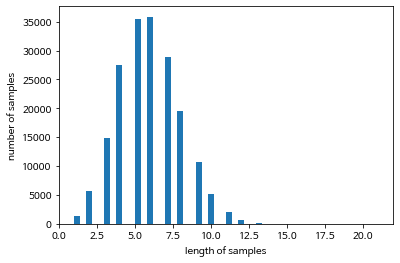

In [ ]:
print('헤드라인의 최대 길이 :',max(len(review) for review in X_train))
print('헤드라인의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 가장 긴 헤드라인의 길이는 21, 평균은 약 5.8정도이다.
- X_train, X_test 모두 병렬 연산을 위해 문장의 길이를 통일해 주어야 함

In [45]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [46]:
max_len = 12
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 12 이하인 샘플의 비율: 99.8375675474823


- 전체 train 데이터 중 약 99%의 헤드라인이 12이하의 길이를 가지므로 max_len을 12로 설정

In [47]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 모델링
- 일단은 baseline
- 하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128
- 출력은 상승 or 하락 중 하나를 예측하는 이진 분류
- 출력층의 활성화함수는 이진분류이므로 시그모이드 사용
- 손실함수는 크로스 엔트로피
- 배치 크기: 64, 에폭: 15

- EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다. 
- ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장한다.
- validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인한다. 
- 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용된다.


### 모델 학습

In [48]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2348/2355 [============================>.] - ETA: 0s - loss: 0.6857 - acc: 0.5461
Epoch 00001: val_acc improved from -inf to 0.52139, saving model to best_model.h5
2355/2355 [==============================] - 19s 5ms/step - loss: 0.6857 - acc: 0.5461 - val_loss: 0.6939 - val_acc: 0.5214
Epoch 2/15
2353/2355 [============================>.] - ETA: 0s - loss: 0.6671 - acc: 0.5936
Epoch 00002: val_acc improved from 0.52139 to 0.52232, saving model to best_model.h5
2355/2355 [==============================] - 13s 6ms/step - loss: 0.6671 - acc: 0.5936 - val_loss: 0.7020 - val_acc: 0.5223
Epoch 3/15
2354/2355 [============================>.] - ETA: 0s - loss: 0.6450 - acc: 0.6274
Epoch 00003: val_acc did not improve from 0.52232
2355/2355 [==============================] - 15s 6ms/step - loss: 0.6450 - acc: 0.6274 - val_loss: 0.7107 - val_acc: 0.5222
Epoch 4/15
2353/2355 [============================>.] - ETA: 0s - loss: 0.6205 - acc: 0.6585
Epoch 00004: val_acc did not improve fr

### 모델 학습 결과

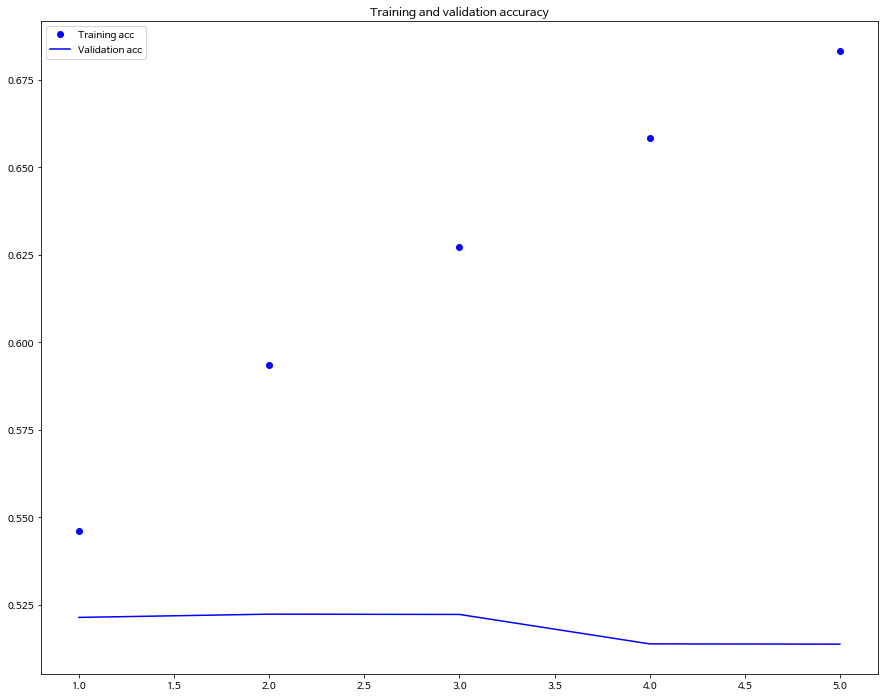

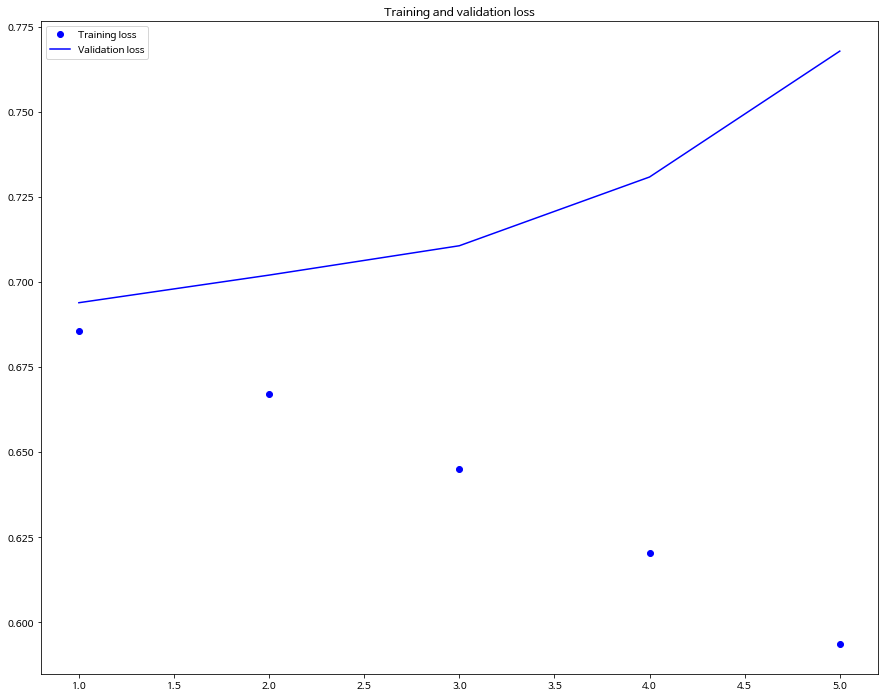

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,12))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure(figsize=(15,12))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- 과적합이 발생했다

### test set 평가 준비
- 예측기로서 동작할 수 있는 Selection Function을 만들어야함
- 특정날짜의 주가 기사문장이 N개라고 했을 때, N개의 문장의 감성 분류스코어를 계산한 확률평균을 그날 주식 종가의 업다운을 결정하는 예측 값으로 사용
- 문장 판별 확률의 평균으로 선택한 이유 -> 일반화된 테스트 데이터가 아님

### 종목별 예측값 mapping df 생성

In [51]:
loaded_model = load_model('best_model.h5') # best model 불러오기

In [52]:
score = loaded_model.predict(X_test)

In [54]:
print('원래 test set 수: ',len(test))
temp = test.drop(drop_test,axis=0,inplace=True)
print('31개 삭제한 test set 수: ',len(test))

원래 test set 수:  45172
31개 삭제한 test set 수:  45141


In [55]:
test['sentiment_prob'] = score
test.head()

,index,name,headline,date,change,token_mecab,sentiment_prob
0,188530,카카오,"""기술 사대주의로는 AI 정복 힘들다""",2020-01-02,0,기술 사대주의 AI 정복 힘들,0.543430
1,188531,카카오,[해설]中 디지털 종속 우려...동남아 국가 '中 QR결제 금지' 초강수,2020-01-02,0,해설 중국 디지털 종속 우려 동남아 국가 중국 QR 결제 금지 강수,0.524929
2,188532,카카오,"씨티은행, 1.3%포인트 금리인하 직장인 신용대출..한달 연장 이벤트",2020-01-02,0,씨티 은행 포인트 금리 인하 직장 신용 대출 연장 이벤트,0.330863
3,188533,카카오,'소비자분쟁 통지서' 카톡으로 제공된다,2020-01-02,0,소비자 분쟁 통지서 카톡 제공,0.413645
4,188534,카카오,[이슈분석]키 잡은 공정위…배민-DH 합병 경우의 수,2020-01-02,0,이슈 분석 공정위 배민 DH 합병 경우,0.410426


In [56]:
loss = test.iloc[drop_test,]
loss[['name','change','date']]

,name,change,date
4587,KB금융,0,2020-03-19
7246,삼성전자,0,2020-05-07
7984,셀트리온,1,2020-05-20
9144,NAVER,0,2020-06-09
9414,현대차,0,2020-06-12
10913,LG화학,0,2020-07-08
11977,LG화학,0,2020-07-24
12423,NAVER,1,2020-08-03
15975,셀트리온,1,2020-09-25
16004,셀트리온,0,2020-09-28


In [57]:
len(test['date'].unique()) # test set -> 2년치 데이터인지 확인

496

In [59]:
stock_prob_list = []
for name in test['name'].unique(): # 10개 종목
    temp_list = []
    for date in tqdm(test['date'].unique()): # 일자 별
        avg_prob = np.mean(test[(test['date'] == date) & (test['name'] == name)]['sentiment_prob']) # 일자별 감성 확률 평균 값
        temp_list.append(avg_prob)  
    stock_prob_list.append(temp_list)

100%|██████████| 496/496 [00:01<00:00, 339.60it/s]


In [60]:
result_df = pd.DataFrame({'카카오': stock_prob_list[0]}, index=test['date'].unique())

for idx, name in enumerate(test['name'].unique()[1:]):
    result_df[name] = stock_prob_list[idx + 1]

In [61]:
result_df.sort_index(inplace=True)

In [62]:
result_df.head()

,카카오,SK하이닉스,KB금융,신한지주,삼성전자,셀트리온,현대차,LG화학,POSCO,NAVER
2020-01-02,0.441799,0.464764,0.444616,0.486764,0.471437,0.379926,0.411993,0.467946,0.473649,0.220484
2020-01-03,0.447051,0.566636,0.457877,0.461653,0.450119,0.413742,0.401189,0.423670,0.570284,0.385583
2020-01-06,0.472941,0.425900,0.315058,0.590625,0.418817,0.401219,0.490809,0.453777,0.414023,0.374548
2020-01-07,0.443253,0.473868,0.447439,NaN,0.490522,0.545502,0.421195,0.424913,0.487397,0.543994
2020-01-08,0.451336,0.490984,0.511493,0.447148,0.456190,0.268173,0.463446,0.401912,0.419364,0.498487


In [63]:
result_df.isnull().sum() # 널값 확인

카카오         0
SK하이닉스      1
KB금융        4
신한지주       83
삼성전자        3
셀트리온        1
현대차         1
LG화학        1
POSCO     137
NAVER       6
dtype: int64

In [64]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2020-01-02 to 2021-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카카오     496 non-null    float64
 1   SK하이닉스  495 non-null    float64
 2   KB금융    492 non-null    float64
 3   신한지주    413 non-null    float64
 4   삼성전자    493 non-null    float64
 5   셀트리온    495 non-null    float64
 6   현대차     495 non-null    float64
 7   LG화학    495 non-null    float64
 8   POSCO   359 non-null    float64
 9   NAVER   490 non-null    float64
dtypes: float64(10)
memory usage: 42.6 KB


- 널 값을 label값과 병합 후에 처리하자

### 종목별 정답 mapping df 생성

In [65]:
change = pd.read_csv('/content/drive/MyDrive/final_project/ten_change.csv', index_col=0)
change.tail()

,date,change,name
24725,2022-01-10,1,신한지주
24726,2022-01-11,1,신한지주
24727,2022-01-12,1,신한지주
24728,2022-01-13,0,신한지주
24729,2022-01-14,0,신한지주


In [66]:
change['date'] = pd.to_datetime(change['date'])

split_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-30')

change_test = change[(change['date'] >= split_date) & (change['date'] <= end_date)]

In [67]:
change_test

,date,change,name
1967,2020-01-02,0,삼성전자
1968,2020-01-03,1,삼성전자
1969,2020-01-06,0,삼성전자
1970,2020-01-07,1,삼성전자
1971,2020-01-08,1,삼성전자
...,...,...,...
24715,2021-12-24,0,신한지주
24716,2021-12-27,0,신한지주
24717,2021-12-28,1,신한지주
24718,2021-12-29,0,신한지주


In [68]:
change_df = pd.DataFrame({'삼성전자': change_test[change_test['name'] == '삼성전자']['change'].values}, index=change_test['date'].unique())
change_df.head()

,삼성전자
2020-01-02,0
2020-01-03,1
2020-01-06,0
2020-01-07,1
2020-01-08,1


In [69]:
for name in change_test['name'].unique()[1:]:
    change_df[name] = change_test[change_test['name'] == name]['change'].values

In [70]:
change_df.tail()

,삼성전자,SK하이닉스,NAVER,LG화학,현대차,카카오,셀트리온,POSCO,KB금융,신한지주
2021-12-24,1,1,1,0,1,1,0,1,0,0
2021-12-27,0,0,0,1,0,0,1,0,0,0
2021-12-28,1,1,1,1,1,1,1,1,1,1
2021-12-29,0,0,0,0,0,1,0,0,0,0
2021-12-30,0,1,0,0,0,0,0,0,0,0


## 종목별 예측값, 정답 병합
    

In [71]:
change_df.columns

Index(['삼성전자', 'SK하이닉스', 'NAVER', 'LG화학', '현대차', '카카오', '셀트리온', 'POSCO',
       'KB금융', '신한지주'],
      dtype='object')

In [72]:
# 각각 데이터프레임 생성

ten_df = []
def make_per_df(name):
  df = pd.DataFrame({'predict':result_df[name],'label': change_df[name]}, index = test['date'].unique())
  df['name'] = name
  df = df.sort_index()
  df.dropna(subset=['predict'],inplace=True)
  return df

def labeling(df):
  df['predict'][df['predict'] < 0.5] = 0
  df['predict'][df['predict'] >= 0.5] = 1
  return df


names = change_df.columns

for name in names:
  df = make_per_df(name)
  label_df = labeling(df)
  ten_df.append(label_df)


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
%matplotlib inline

In [74]:
acc_list = []
company = ['samsung elec', 'sk hynix', 'naver', 'lg chem', 'hyundai car', 'kakao', 'celtrion', 'posco', 'kb finance', 'shinhan']
for df in ten_df:
  acc_list.append(accuracy_score(df['label'], df['predict']))

In [75]:
acc_df = pd.DataFrame({'company': company, 'accuracy': acc_list})
acc_df.set_index('company', inplace=True)

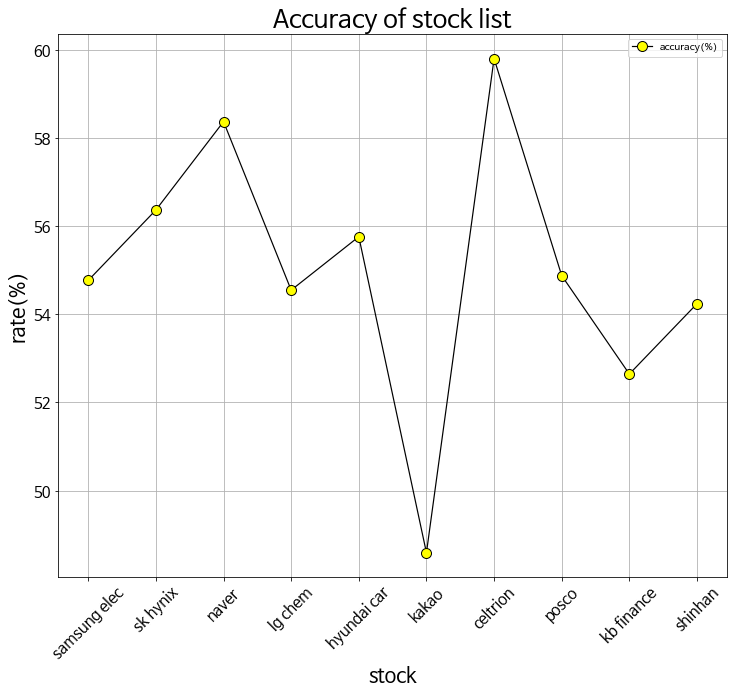

In [76]:
plt.figure(figsize=(12, 10))
plt.plot(acc_df.index, acc_df['accuracy'] * 100,
         label='accuracy(%)',
         linestyle='-',
         linewidth=1.2,
         color='black',
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='black'
)

plt.title('Accuracy of stock list', size=25)
plt.xlabel("stock", size=20)
plt.ylabel("rate(%)", size=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(loc='best')
plt.show()

## 종목별 confusion matrix, classification_report

In [77]:
ten_df[0].name.unique()[0]

'삼성전자'

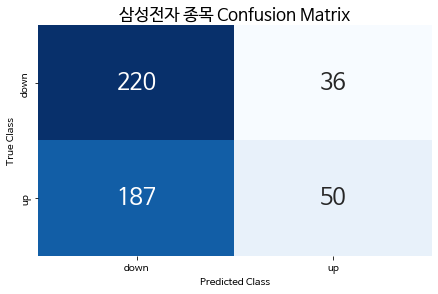

              precision    recall  f1-score   support

        down       0.54      0.86      0.66       256
          up       0.58      0.21      0.31       237

    accuracy                           0.55       493
   macro avg       0.56      0.54      0.49       493
weighted avg       0.56      0.55      0.49       493



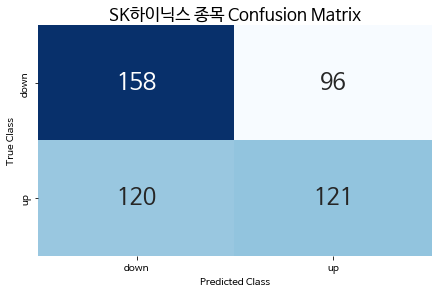

              precision    recall  f1-score   support

        down       0.57      0.62      0.59       254
          up       0.56      0.50      0.53       241

    accuracy                           0.56       495
   macro avg       0.56      0.56      0.56       495
weighted avg       0.56      0.56      0.56       495



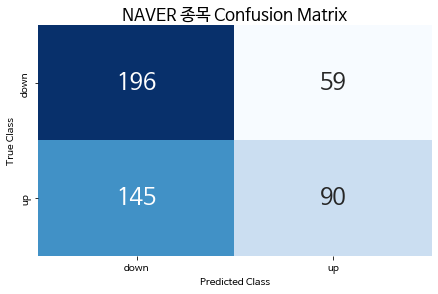

              precision    recall  f1-score   support

        down       0.57      0.77      0.66       255
          up       0.60      0.38      0.47       235

    accuracy                           0.58       490
   macro avg       0.59      0.58      0.56       490
weighted avg       0.59      0.58      0.57       490



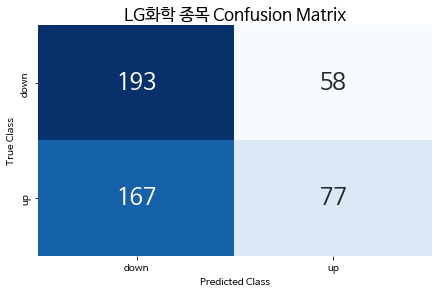

              precision    recall  f1-score   support

        down       0.54      0.77      0.63       251
          up       0.57      0.32      0.41       244

    accuracy                           0.55       495
   macro avg       0.55      0.54      0.52       495
weighted avg       0.55      0.55      0.52       495



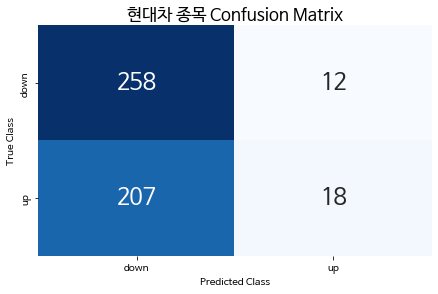

              precision    recall  f1-score   support

        down       0.55      0.96      0.70       270
          up       0.60      0.08      0.14       225

    accuracy                           0.56       495
   macro avg       0.58      0.52      0.42       495
weighted avg       0.58      0.56      0.45       495



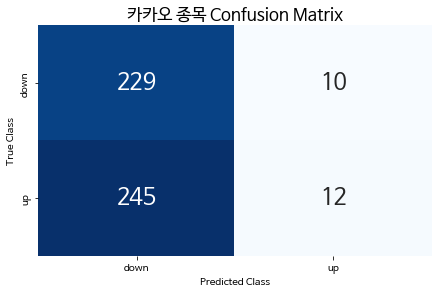

              precision    recall  f1-score   support

        down       0.48      0.96      0.64       239
          up       0.55      0.05      0.09       257

    accuracy                           0.49       496
   macro avg       0.51      0.50      0.36       496
weighted avg       0.52      0.49      0.35       496



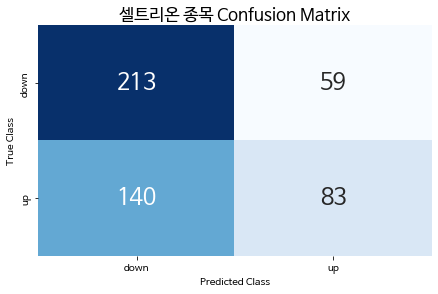

              precision    recall  f1-score   support

        down       0.60      0.78      0.68       272
          up       0.58      0.37      0.45       223

    accuracy                           0.60       495
   macro avg       0.59      0.58      0.57       495
weighted avg       0.59      0.60      0.58       495



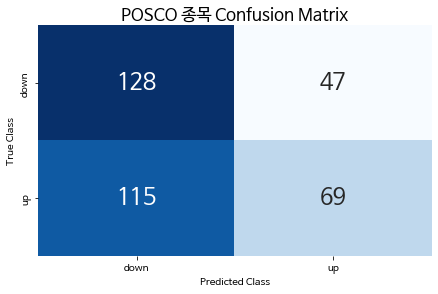

              precision    recall  f1-score   support

        down       0.53      0.73      0.61       175
          up       0.59      0.38      0.46       184

    accuracy                           0.55       359
   macro avg       0.56      0.55      0.54       359
weighted avg       0.56      0.55      0.53       359



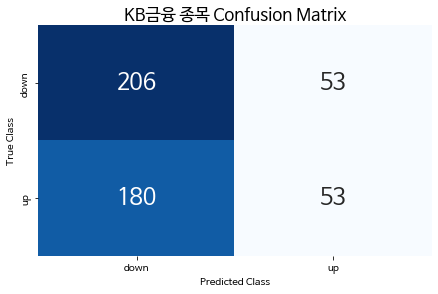

              precision    recall  f1-score   support

        down       0.53      0.80      0.64       259
          up       0.50      0.23      0.31       233

    accuracy                           0.53       492
   macro avg       0.52      0.51      0.48       492
weighted avg       0.52      0.53      0.48       492



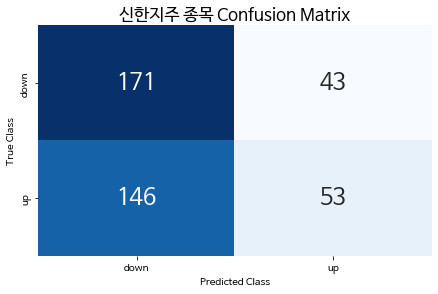

              precision    recall  f1-score   support

        down       0.54      0.80      0.64       214
          up       0.55      0.27      0.36       199

    accuracy                           0.54       413
   macro avg       0.55      0.53      0.50       413
weighted avg       0.55      0.54      0.51       413



In [78]:
def make_confusion_matrix(df):
  matrix = confusion_matrix(df.label, df.predict)
  class_names = ['down', 'up']
  dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

  sns.heatmap(dataframe, annot=True, annot_kws = {'size' : 23}, fmt='d', cbar=None, cmap='Blues')
  name = df.name.unique()[0]
  plt.title(f'{name} 종목 Confusion Matrix',size=17)
  plt.tight_layout()
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class')
  plt.show()
  print(classification_report(df.label, df.predict, target_names=class_names))

for df in ten_df:
  make_confusion_matrix(df)

In [79]:
#acc_list = []; 
precision_up = []; precision_down = []
company = ['samsung elec', 'sk hynix', 'naver', 'lg chem', 'hyundai car', 'kakao', 'celtrion', 'posco', 'kb finance', 'shinhan']
for df in ten_df:
  #acc_list.append(accuracy_score(df['label'], df['predict']))
  precision_up.append(precision_score(df['label'], df['predict'],pos_label=1))
  precision_down.append(precision_score(df['label'], df['predict'],pos_label=0))

In [80]:
pre_up = pd.DataFrame({'company': company, 'precision': precision_up})
pre_down = pd.DataFrame({'company': company, 'precision': precision_down})
pre_up.set_index('company', inplace=True)
pre_down.set_index('company', inplace=True)

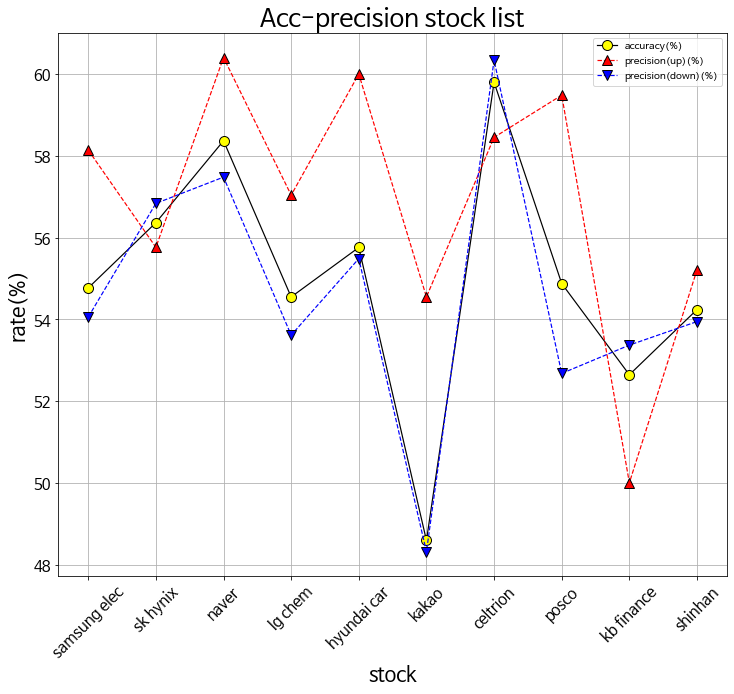

In [81]:
plt.figure(figsize=(12, 10))
plt.plot(acc_df.index, acc_df['accuracy'] * 100,
         label='accuracy(%)',
         linestyle='-',
         linewidth=1.2,
         color='black',
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='black'
)

plt.plot(pre_up.index, pre_up['precision'] * 100,
         label='precision(up)(%)',
         linestyle='--',
         linewidth=1.2,
         color='red',
         marker='^',
         markersize=10,
         markerfacecolor='red',
         markeredgecolor='black'
)

plt.plot(pre_down.index, pre_down['precision'] * 100,
         label='precision(down)(%)',
         linestyle='--',
         linewidth=1.2,
         color='blue',
         marker='v',
         markersize=10,
         markerfacecolor='blue',
         markeredgecolor='black'
)

plt.title('Acc-precision stock list', size=25)
plt.xlabel("stock", size=20)
plt.ylabel("rate(%)", size=20)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(loc='best')
plt.show()

- accuracy : 전체 데이터에서 제대로 예측했는지 지표
- precision : 모델이 1이라고 예측한 데이터 중 실제 1인 데이터의 비율
- recall : 실제 1인 데이터에서 1이라고 예측한 데이터의 비율

---